# Assignment 2: Sequence Modeling

## Introduction
In this assignment, we will explore language model inference and training. You will implement various inference algorithms and train a number of simple LMs, ranging from n-gram models to sequence to sequence with attention models.

Learning objectives:
* Understand how to implement different LM generation algorithms.
* Grasp core properties of the different generation algorithms.
* Understand how to implement and train various LMs, ranging from n-gram models to sequence to sequence architectures.
* Understand the tradeoffs of various modeling decisions when training an LM.

**Notes:**
* In your solution, keep all code as-is except where it's explicitly mentioned to implement a function.
* Items marked with a star (★) should be answered in markdown text in the notebook. You will include your final notebook as a pdf with your submission.
* We will automatically save files with results to the results sub-directory, these will be used for autograding. You should submit the results directory with your assignment on gradescope.

**Submission:**

You will submit:

* A PDF copy of your completed notebook. This should be titled "HW1.pdf". This is used to grade your answers to the problems marked with a (★).
* All the json files saved inside the `results/` directory. These will be autograded.

**Setup:**

We reccomend running this notebook in Collab, as many of the sections will run much faster on a GPU. You should upload the notebook to Collab and select T4 as the GPU, by selecting "Runtime -> Change Runtime Type".

# 1. Using a Sequence Model (25 Points)

### 1.0 Setup

In [1]:
!pip install huggingface_hub datasets transformers
!pip install torch torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00


In [2]:
from typing import List
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import json

# Load tokenizer/model
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B")
model.to("cuda")
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotar

We will use the following function to compute the next token prediction scores for a given prefix.

In [88]:
@torch.inference_mode()
def get_next_token_scores(prefix: List[int]) -> List[float]:
    """
    Return raw next-token scores (logits) s(* | prefix), where prefix is a list of token ids.
    """
    out = model(input_ids=torch.tensor(prefix).unsqueeze(0).to(model.device))
    next_logits = out.logits[:, -1, :].squeeze(0)
    return next_logits.detach().cpu().tolist()

For the following problems you will need to convert token indicies to string and string to token indicies. You can use the following to do that.

In [4]:
def str_to_tokens(text: str) -> List[int]:
  return tokenizer.encode(text)

def tokens_to_str(tokens: List[int]) -> str:
  return tokenizer.decode(tokens)

#### Data

We will use a set of paired sentences in Russian and English for this assignment. We will compute and compare the probabilities of sequences from both languages. We will use 60 sentences from each language.

In [59]:
# from datasets import load_dataset

# # Load using the local script
# dataset = load_dataset("wmt/wmt19", 'ru-en', split='validation')
# english_sentences, russian_sentences = zip(*[(sentence['en'], sentence['ru']) for sentence in dataset['translation'][:60]])

# instead we can load from the pre-downloaded files
import json
with open("english.json", "r") as f:
  english_sentences = json.load(f)
with open("russian.json", "r") as f:
  russian_sentences = json.load(f)

In [60]:
english_sentences

['Russian President Vladimir Putin has signed a law on the establishment of administrative liability for violating the deadline and procedures for payment of goods (works, services) as part of procurement for state and municipal needs.',
 'This law is meant to solve the very serious issue of customers failing to fulfill their commitments as part of state and municipal procurements.',
 'Just two years ago, situations in which business owners were unable to collect payment for already-executed state and municipal contracts were widespread.',
 'At that time, the Russian president tasked the Office of Prosecutor General of the Russian Federation with taking the issue under special control.',
 'After all, businessmen couldn’t deal on their own with dishonest customers who signed agreements without financial backing, tried their best to get out of assumed payment commitments, and included illegal conditions in agreements.',
 'The problem was systemic throughout the entire country.',
 'Since 

In [61]:
russian_sentences

['Президент России Владимир Путин подписал закон о введении административной ответственности за нарушение срока и порядка оплаты товаров (работ, услуг) при осуществлении закупок для государственных и муниципальных нужд.',
 'Этот закон призван решить весьма острую проблему неисполнения своих обязательств заказчиками при осуществлении государственных и муниципальных закупок.',
 'Еще два года назад ситуация, когда предприниматели не могли получить оплату по уже исполненным государственным и муниципальным контрактам, была повсеместной.',
 'Тогда же президент России дал поручение Генеральной прокуратуре РФ взять проблему на особый контроль.',
 'Потому что сами бизнесмены не могли справиться с недобросовестными заказчиками, которые заключали не подкрепленные финансированием контракты, всячески пытались уклониться от взятых обязательств по оплате и включали в договоры незаконные условия.',
 'Проблема была системной в целом в стране.',
 'С 2015 года в интересах защиты прав предпринимателей на 

### 1.1 Scoring Sequences (10 Points)

You will implement a function that computes the probability p(* | prefix) over wordtypes in the vocabulary given scores, with a temperature parameter (default to 1).

In [82]:
import numpy as np

def softmax(logits, temp = 1):
    z = np.asarray(logits) / temp
    z -= z.max()
    p = np.exp(z)
    return p / p.sum()

def next_tok_prob(prefix: List[int], temperature: float):
  prefix = [int(t) for t in prefix]
  logits = get_next_token_scores(prefix)
  return softmax(logits, temperature)


Now, you will implement a function that uses your p(* | prefix) function. to compute the negative log likelihood of a given sequence using chain rule decomposition of sequence probabilities.

In [83]:
def sequence_prob(prefix: str, text: str, temperature: float):
  tokenized_prefix = str_to_tokens(prefix)
  tokenized_sequence = str_to_tokens(text)
  log_prob = 0.0
  for token in tokenized_sequence:
      p = next_tok_prob(tokenized_prefix, temperature)
      log_prob += np.log(p[token] + 1e-14)
      tokenized_prefix.append(token)
  return float(np.exp(log_prob))

In [93]:
all_sentences = english_sentences + russian_sentences
values = []
for s in all_sentences:
  tokens = str_to_tokens(s)
  prefix = tokens_to_str(tokens[:1])
  cont = tokens_to_str(tokens[1:])

  p = sequence_prob(prefix, cont, 1.0)
  nll = -np.log(p + 1e-14)
  nll_normalized = nll / (len(tokens) - 1)
  values.append((s, nll, nll_normalized))

lowest_total_nll  = sorted(values, key=lambda t: t[1])[:20]
highest_total_nll = sorted(values, key=lambda t: t[1], reverse=True)[:20]

print("Lowest TOTAL NLL")
for s, _, _ in lowest_total_nll:
    print(s)

print("Highest TOTAL NLL")
for s, _, _ in highest_total_nll:
    print(s)

lowest_norm_nll  = sorted(values, key=lambda t: t[2])[:20]
highest_norm_nll = sorted(values, key=lambda t: t[2], reverse=True)[:20]

print("Lowest LENGTH-NORMALIZED NLL")
for s, _, _ in lowest_norm_nll:
    print(s)

print("Highest LENGTH-NORMALIZED NLL")
for s, _, _ in highest_norm_nll:
    print(s)


Lowest TOTAL NLL
Here is a typical case.
Вот характерный случай.
All the wounded were taken to hospital.
Все раненые доставлены в больницу.
Один из злоумышленников задержан, второму удалось скрыться.
Civil rights group issues travel warning for Missouri
Владимир Путин поручил ликвидировать загрязнения Байкала
"We are hearing complaints at a rate we haven't heard before."
Два человека погибли в результате стрельбы по полицейскому патрулю в Египте
Проект закона был разработан Минэкономразвития России по инициативе Генпрокуратуры.
The problem was systemic throughout the entire country.
Vladimir Putin has ordered the cleanup of pollution in Baikal
Проблема была системной в целом в стране.
One of the perpetrators has been apprehended, but the second managed to escape.
Во время перестрелки два человека, в том числе один полицейский, погибли, три человека получили ранения.
«У вас люди подвергаются нарушению прав человека.
«Мы слышим жалобы часто, как никогда раньше».
"You have violations of c

**Report** Compute negative log likelihood for all of the sequences in the dataset.

★ The 20 sentences with the highest and lowest total negative log likelihoods across the two datasets combined.

★ The 20 sentences with the highest and lowest total negative log likelihoods, normalized by sequence length, across the two datasets combined.

★ What properties do high-likelihood sequences have that low-probability ones don’t?

★ How does normalizing by sequence length influence this?

I think high likelihood sentences are generally more coherent and are highly simple. They usually have a single clause with minimal added stuff and are also shorter. I think that they also have very simple words too.

Length normalization influences this since it means that sequences that are long but simple also are highly likely. This is because without normalizing for length, shorter sequences always appeared as more likely. This meant that many long news reports started to become highly likely after doing length normalization



Now we will implement a function that computes the perplexity of an entire text dataset.

**NOTE: this model does not have a BOS token, so we will use the first token in each sequence as the prefix.**

In [64]:
def dataset_perplexity(sentences: List[str], temperature: float):
	total_neg_logprob = 0.0
	total_tokens = 0

	for s in sentences:
		tokens = str_to_tokens(s)
		if len(tokens) <= 1:
				continue
		prefix = [tokens[0]]
		for tok in tokens[1:]:
				p = next_tok_prob(prefix, temperature)
				total_neg_logprob += -np.log(max(float(p[tok]), 1e-14))
				prefix.append(tok)
		total_tokens += (len(tokens) - 1)

	return float(np.exp(total_neg_logprob / total_tokens))

In [ ]:
# fill in your answers for the perplexity of the entire datasets here
perplexity_en = dataset_perplexity(english_sentences, 1.0)
perplexity_ru = dataset_perplexity(russian_sentences, 1.0)

with open("results/perplexities.json", "w") as f:
	json.dump({"en": perplexity_en, "ru": perplexity_ru}, f)

### 1.2 Generating Sequences (15 Points)

Implement a function that visualizes two statistics of a set of sequences:

(a) the distribution of sequence lengths.

(b) frequency-rank distributions of the wordtypes in the vocabulary for different sets of sequences.

In [65]:
from typing import List
import matplotlib.pyplot as plt
from collections import Counter

def sequence_length_distribution(sentences: List[str]):
    lengths = [len(str_to_tokens(s)) for s in sentences]
    plt.figure()
    plt.hist(lengths, bins=range(1, max(lengths) + 2), align="left", edgecolor="black")
    plt.xlabel("Sequence length (tokens)")
    plt.ylabel("Count")
    plt.title("Sequence length distribution")
    plt.show()

def frequency_rank_distribution(sentences: List[str]):
    tokens = []
    for s in sentences:
        tokens += str_to_tokens(s)
    counts = Counter(tokens)
    freqs = sorted(counts.values(), reverse=True)
    ranks = range(1, len(freqs) + 1)
    plt.figure()
    plt.loglog(ranks, freqs, marker="o")
    plt.xlabel("Rank (1 = most frequent)")
    plt.ylabel("Frequency")
    plt.title("Frequency–rank (Zipf) distribution")
    plt.show()

Now compute these distributions for the english and russian datasets used in 1.1.

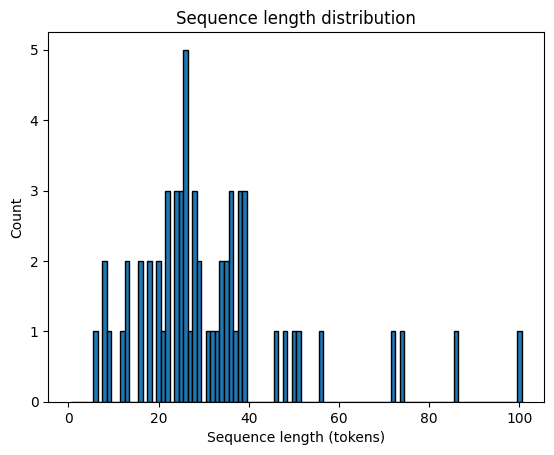

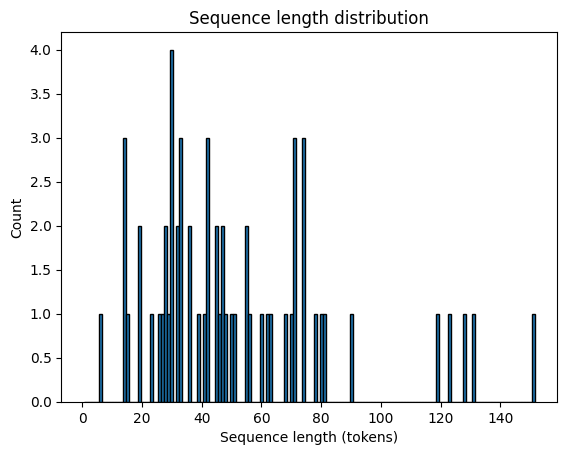

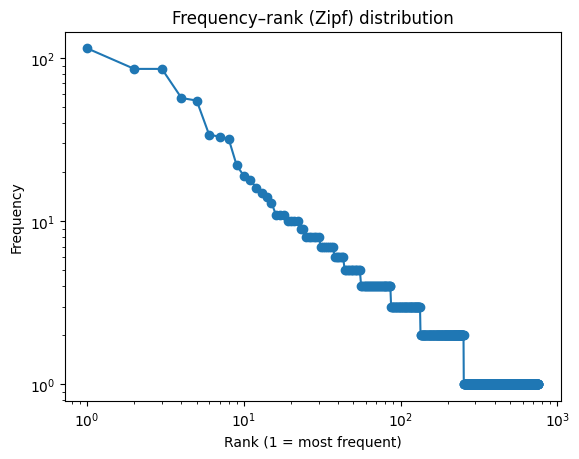

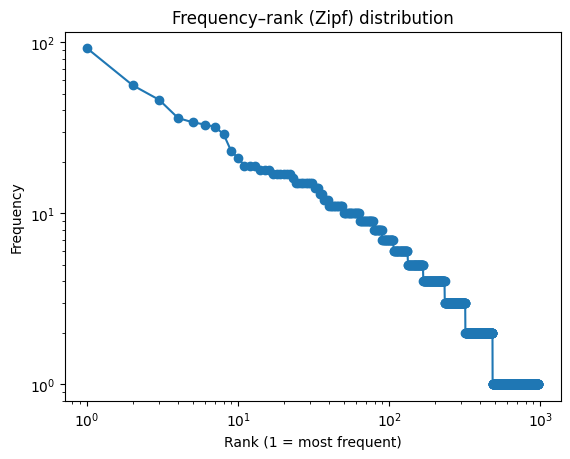

In [66]:
en_length_dist = sequence_length_distribution(english_sentences)
ru_length_dist = sequence_length_distribution(russian_sentences)

en_freq_dist = frequency_rank_distribution(english_sentences)
ru_freq_dist = frequency_rank_distribution(russian_sentences)

Implement a function that uses ancestral sampling on top of p(* | prefix) to generate sequences. This function should also be able to use the temperature parameter of p(* | prefix).

In [67]:
def generate_sequence(prefix: str, temperature: float, max_length: int):
	prefix_tokens = str_to_tokens(prefix)
	for i in range(max_length):
			logits = get_next_token_scores(prefix_tokens)
			if temperature == 0.0:
					next_token = int(np.argmax(logits))
			else:
					p = softmax(logits, temperature)
					next_token = int(np.random.choice(len(p), p=p))
			prefix_tokens.append(next_token)
	return tokens_to_str(prefix_tokens)

Now use this function to sample 50 texts with max_length of 100 for each temperature value in {0, 0.7, 1, 1.2} using the prefix "hello" and compare their vocabulary distributions.

★ Why might temperature result in the observed differences?

Different temperatures lead to different levels of creativity for the model responses, so it can lead to much different generations

In [15]:
from tqdm import tqdm
vocab_dist_per_temp = {0.0: None, 0.7: None, 1.0: None, 1.2: None}
# each value in vocab_dist_per_temp should be a dictionary mapping each word to its frequency count in the generated texts

# TODO sample 50 texts for each temperature value in {0, 0.7, 1, 1.2} using the prefix "hello" and compare their vocabulary distributions. Why might temperature result in the observed differences?
temperatures = [0.0, 0.7, 1.0, 1.2]
for temp in temperatures:
    samples = [generate_sequence(prefix="hello", temperature=temp, max_length=100) for _ in tqdm(range(50))]
    counts = Counter()
    for gen in samples:
        for token in str_to_tokens(gen):
            counts[tokens_to_str([token])] += 1
    vocab_dist_per_temp[temp] = dict(counts)
with open("results/vocab_distributions_per_temp.json", "w") as f:
	json.dump(vocab_dist_per_temp, f)

100%|██████████| 50/50 [04:14<00:00,  5.08s/it]


Implement a function that modifies and renormalizes p(* | prefix) for ϵ-sampling.

In [68]:
def generate_sequence_epsilon(prefix: str, temperature: float, epsilon: float, max_length: int):
    tokens = str_to_tokens(prefix)
    for i in range(max_length):
        logits = get_next_token_scores(tokens)
        if temperature == 0.0:
            next_token = int(np.argmax(logits))
        else:
            p = softmax(logits, temperature)
            keep_inds = np.where(p >= epsilon)[0]
            if len(keep_inds) > 0:
                kept = p[keep_inds]
                kept /= kept.sum()
                next_token = int(np.random.choice(keep_inds, p=kept))
            else:
                next_token = int(np.random.choice(len(p), p=p))
        tokens.append(next_token)
    return tokens_to_str(tokens)

Report Use ancestral sampling with temperature = 1 and ϵ in {0, 0.05, 0.1} to sample 50 texts of max length 100 for each value of ϵ using the prefix "hello", and compare their vocabulary distributions.

★ Why might ϵ result in the observed differences?


ϵ might lead to differences since it will change how many tail tokens are samples. Higher values of ϵ will mean that less tail values are sampled, so lower ϵ might lead to more diverse generations

In [49]:
vocab_dist_per_epsilon = {0.0: None, 0.05: None, 0.1: None}
# each value in vocab_dist_per_epsilon should be a dictionary mapping each word to its frequency count in the generated texts

epsilons = [0.0, 0.05, 0.1]
for e in epsilons:
    samples = [generate_sequence_epsilon(prefix="hello", temperature=1.0, epsilon = e, max_length=100) for _ in tqdm(range(50))]
    counts = Counter()
    for gen in samples:
        for token in str_to_tokens(gen):
            counts[tokens_to_str([token])] += 1
    vocab_dist_per_epsilon[e] = dict(counts)

with open("results/vocab_distributions_per_epsilon.json", "w") as f:
	json.dump(vocab_dist_per_epsilon, f)

100%|██████████| 50/50 [04:04<00:00,  4.89s/it]


Implement a function that modifies and renormalizes p(* | prefix) for top-k sampling.

In [69]:
def generate_sequence_top_k(prefix: str, temperature: float, top_k: float, max_length: int):
    tokens = str_to_tokens(prefix)
    for i in range(max_length):
        logits = get_next_token_scores(tokens)
        if temperature == 0.0:
            next_token = int(np.argmax(logits))
        else:
            p = softmax(logits, temperature)
            k = min(top_k, len(p))
            top_inds = np.argsort(p)[-k:]
            top_probs = p[top_inds]
            top_probs /= top_probs.sum()
            next_token = int(np.random.choice(top_inds, p=top_probs))
        tokens.append(next_token)
    return tokens_to_str(tokens)

Report Use ancestral sampling with temperature = 1 and k in {1, 20, 100} to sample 50 texts with max_length 100 tokens for each value of k with the prefix "hello", and compare their vocabulary distributions.

★ Why might k result in the observed differences?

Lower values of k lead to more deterministic responses and ends up leading to less tail generations. Thus, higher values of k might lead to more diverse generations

In [51]:
vocab_dist_per_k = {1: None, 20: None, 100: None}
# each value in vocab_dist_per_k should be a dictionary mapping each word to its frequency count in the generated texts

ks = [1, 20, 100]
for k in ks:
    samples = [generate_sequence_top_k(prefix="hello", temperature=1.0, top_k = k, max_length=100) for _ in tqdm(range(50))]
    counts = Counter()
    for gen in samples:
        for token in str_to_tokens(gen):
            counts[tokens_to_str([token])] += 1
    vocab_dist_per_k[k] = dict(counts)

with open("results/vocab_distributions_per_k.json", "w") as f:
	json.dump(vocab_dist_per_k, f)

100%|██████████| 50/50 [04:26<00:00,  5.34s/it]


Implement a function that modifies and renormalizes p(* | prefix) for top-p (nucleus) sampling.

In [70]:
def generate_sequence_top_p(prefix: str, temperature: float, top_p: float, max_length: int):
    tokens = str_to_tokens(prefix)
    for i in range(max_length):
        logits = get_next_token_scores(tokens)
        if temperature == 0.0:
            next_token = int(np.argmax(logits))
        else:
            p = softmax(logits, temperature)
            sorted_indices = np.argsort(p)[::-1]
            kept_indices = []
            total = 0.0
            for j in sorted_indices:
                kept_indices.append(j)
                total += p[j]
                if total >= top_p:
                    break
            q = p[kept_indices]
            q /= q.sum()
            next_token = int(np.random.choice(kept_indices, p=q))
        tokens.append(next_token)
    return tokens_to_str(tokens)

Report Use ancestral sampling with temperature = 1 and p in {0.5, 0.9, 1.0} to sample 50 texts with max_length 100 for each value of p with the prefix "hello", and compare their length and vocabulary distributions.

★ Why might p result in the observed differences?

p results in the observed differences since lower p means that a less number of tokens are selected to sample from. Thus, higher values of p will lead to a longer tail to choose from and thus more diverse generations

In [23]:
from tqdm import tqdm
vocab_dist_per_p = {0.5: None, 0.9: None, 1.0: None}
# each value in vocab_dist_per_p should be a dictionary mapping each word to its frequency count in the generated texts

ps = [0.5, 0.9, 1.0]
for p in ps:
    samples = [generate_sequence_top_p(prefix="hello", temperature=1.0, top_p = p, max_length=100) for _ in tqdm(range(50))]
    counts = Counter()
    for gen in samples:
        for token in str_to_tokens(gen):
            counts[tokens_to_str([token])] += 1
    vocab_dist_per_p[p] = dict(counts)

with open("results/vocab_distributions_per_p.json", "w") as f:
	json.dump(vocab_dist_per_p, f)

100%|██████████| 50/50 [10:56<00:00, 13.14s/it]


# 2. Implementing sequence models (25 Points)

### 2.0 Setup

In [8]:
# This block handles basic setup and data loading using HuggingFace datasets.

# imports
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset

# Load WikiText2 from HuggingFace
print("Loading WikiText2 dataset from HuggingFace (Salesforce/wikitext)...")
wikitext2 = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")

# Process the data to create token lists
def process_wikitext_split(split_data):
    """Convert HuggingFace dataset split to list of tokens."""
    tokens = []
    for example in split_data:
        text = example['text'].strip()
        if text:  # Skip empty lines
            # Simple whitespace tokenization
            tokens.extend(text.split())
    return tokens

train_text = process_wikitext_split(wikitext2['train'])
validation_text = process_wikitext_split(wikitext2['validation'])
test_text = process_wikitext_split(wikitext2['test'])

# Build vocabulary from training data
print("Building vocabulary...")
word_counts = Counter(train_text)

# Create a vocab class to match torchtext interface
class SimpleVocab:
    def __init__(self, word_counts, special_tokens=['<unk>', '<eos>']):
        self.itos = special_tokens.copy()
        self.unk_index = 0  # Index of <unk> token (first special token)

        # Build initial stoi mapping
        _stoi = {token: idx for idx, token in enumerate(self.itos)}

        # Add all words from training data, sorted by frequency (most common first)
        for word, count in word_counts.most_common():
            if word not in _stoi:
                _stoi[word] = len(self.itos)
                self.itos.append(word)

        # Use defaultdict to return <unk> index for unknown words
        # This matches torchtext behavior where unknown words map to <unk>
        self.stoi = defaultdict(lambda: self.unk_index, _stoi)

    def __len__(self):
        return len(self.itos)

vocab = SimpleVocab(word_counts)
vocab_size = len(vocab)

print("Data loading complete!")
print("Number of words in the vocabulary: {}".format(vocab_size))
print("Number of tokens in training set: {}".format(len(train_text)))
print("Number of tokens in validation set: {}".format(len(validation_text)))
print("Number of tokens in test set: {}".format(len(test_text)))
print("Example text: {}".format(validation_text[:30]))

Loading WikiText2 dataset from HuggingFace (Salesforce/wikitext)...


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Building vocabulary...
Data loading complete!
Number of words in the vocabulary: 76618
Number of tokens in training set: 2051910
Number of tokens in validation set: 213886
Number of tokens in test set: 241211
Example text: ['=', 'Homarus', 'gammarus', '=', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', 'clawed', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean', ',', 'Mediterranean', 'Sea']


We've implemented a unigram model here as a demonstration.

In [9]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in vocab.itos]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.

        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(max(self.probability(word), 1e-8), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:',
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities,
    it is still good to have a separate more efficient method that only computes
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab.stoi[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 2051.6368254004396


To generate from the model, we can sample one word at a time conditioning on the words we have generated so far, just like how we did in the previous part.

In [10]:
# Note: the prefix tokens will be used by our trigram language model
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(vocab.itos, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> = were in just was ) Organization layered 's single Mecke to initially type weather the juice watershed of Jeff


You will need to submit some outputs from the models you implement for us to grade. The following function will be used to generate the required output files.

In [11]:
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes_short.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab_short.txt

def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.

    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'eval_output_vocab'
    prefixes_name = 'eval_prefixes'

    if short:
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab.stoi[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in lines:
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

--2025-11-04 02:59:55--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519055 (507K) [text/plain]
Saving to: ‘eval_prefixes.txt’

eval_prefixes.txt   100%[===================>] 506.89K  --.-KB/s    in 0.005s  

2025-11-04 02:59:56 (90.8 MB/s) - ‘eval_prefixes.txt’ saved [519055/519055]

--2025-11-04 02:59:56--  https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
Resolving cal-cs288.github.io (cal-cs288.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to cal-cs288.github.io (cal-cs288.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12497 (12K) [text/plain]
Saving to: ‘eval_output_vocab.txt’

eval_output_

In [34]:
save_truncated_distribution(unigram_demonstration_model, 'results/unigram_demonstration_predictions.npy')

saved results/unigram_demonstration_predictions.npy


### 2.1 N-gram Model (5 Points)

Now it's time to implement an n-gram language model.

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{C(w_1,w_2)+\alpha}{C(w_1)+\alpha\cdot|V|}$$

where $|V|$ is the vocab size and $C$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff. One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity below 1500 on the validation set. Please note that the trigram model will probably have a very high perplexity at this point, due to sparsity issues. We'll correct this below.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass.
Also, we suggest pre-computing and caching the counts $C$ when you initialize `NGramModel` for efficiency.

In [35]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha
        self.ngram_counts = Counter()
        self.old_counts = Counter()

        if self.n == 1:
          for word in train_text:
            self.ngram_counts[(word, )] += 1
            self.old_counts[()] += 1
          self.smoothing = 0.0
        else:
          for i in range(self.n - 1, len(train_text)):
            history = tuple(train_text[i - (self.n - 1): i])
            word = train_text[i]
            self.ngram_counts[history + (word, )] += 1
            self.old_counts[history] += 1

    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.

        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n
        history = tuple(n_gram[:-1])
        word = n_gram[-1]
        if len(history) < self.n - 1:
          return 1 / vocab_size

        prior_count = self.old_counts.get(history, 0)
        new_count = self.ngram_counts.get(tuple(n_gram), 0)
        alpha_count = self.smoothing * vocab_size
        return (new_count + self.smoothing) / (prior_count + alpha_count)
        # END SOLUTION

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        if self.n > 1:
          history = tuple(text_prefix[-(self.n - 1):])
        else:
          history = ()

        if self.n > 1 and len(history) < self.n - 1:
          return [1.0 / vocab_size] * vocab_size

        probs = []

        for word in vocab.itos:
          probs.append(self.n_gram_probability(list(history) + [word]))

        total = sum(probs)
        probs = [p / total for p in probs]
        return probs
        # END SOLUTION

    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """

        # YOUR CODE HERE
        # use your function n_gram_probability
        # This method should differ a bit from the example unigram model because
        # the first n-1 words of full_text must be handled as a special case.

        # BEGIN SOLUTION
        logprobs = []
        for i, word in enumerate(full_text):
          if self.n == 1:
            curr_ngram = [word]
          else:
            if i < self.n - 1:
              logprobs.append(math.log(max(1/vocab_size, 1e-14)))
              continue
            history = list(full_text[i - (self.n - 1): i])
            curr_ngram = history + [word]
          logprobs.append(math.log(max(self.n_gram_probability(curr_ngram), 1e-14)))

        return math.exp(-np.mean(logprobs))

        # END SOLUTION

unigram_model = NGramModel(train_text, 1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...
save_truncated_distribution(bigram_model, 'results/bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 3262.874352122553
bigram validation perplexity: 1448.8367175084252
trigram validation perplexity: 10155.130827497205
saved results/bigram_predictions.npy


Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: ***1448.8367175084252***

We can also generate samples from the model to get an idea of how it is doing.

In [36]:
print(generate_text(bigram_model))

<eos> <eos> 7.d4 antithesis digits ankh Abruzzi stegosaurian Vincoli reservation Three battalions of the productions consumes Titanium Goyanes Asan Farman Andrew engrossed


We now free up some RAM, **it is important to run the cell below, otherwise you will likely run out of RAM in the Colab runtime.**

In [37]:
# Free up some RAM.
del bigram_model
del trigram_model

### 2.2 N-gram Backoff (5 Points)

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting:
$$
\begin{align}
P\left(w_i|w_{i-n+1}^{i-1}\right)&=\frac{max\left\{C(w_{i-n+1}^i)-\delta,0\right\}}{\sum_{w_i} C\left(w_{i-n+1}^i\right)} + \alpha\left(w_{i-n+1}^{i-1}\right) P\left(w_i|w_{i-n+2}^{i-1}\right) \\
\alpha\left(w_{i-n+1}^{i-1}\right)&=\frac{\delta N_{1+}\left(w_{i-n+1}^{i-1}\right)}{{\sum_{w_i} C\left(w_{i-n+1}^i\right)}}
\end{align}
$$
where $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $\sum_{w_i} C(w_{i-n+1}^i)=0$, use the lower order model probability directly (the above equations would have a division by 0). We found a discount $\delta$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 700.

In [38]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta

        self.n1_counts = Counter()
        for k in self.ngram_counts.keys():
          history = k[:-1]
          self.n1_counts[history] += 1

    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n

        history = tuple(n_gram[:-1])
        word = n_gram[-1]

        if len(history) < self.n - 1:
          return self.lower_order_model.n_gram_probability(n_gram[1:])

        denom = self.old_counts.get(history, 0)
        if denom == 0:
          return self.lower_order_model.n_gram_probability(n_gram[1:])

        count = self.ngram_counts.get(tuple(n_gram), 0)
        discount = max(count - self.discount, 0) / denom
        alpha = (self.discount * self.n1_counts.get(history, 0)) / denom

        backoff = self.lower_order_model.n_gram_probability(n_gram[1:])

        return discount + alpha * backoff

bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

save_truncated_distribution(trigram_backoff_model, 'results/discount_backoff_predictions.npy') # this might take a few minutes

trigram backoff validation perplexity: 956.2834128882408
saved results/discount_backoff_predictions.npy


Free up RAM.

In [39]:
# Release models we don't need any more.
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

### 2.3 Smoothed N-gram Model (5 Points)

Now, implement Kneser-Ney to replace the unigram base model.
$$P(w)\propto |\{w':c(w',w) > 0\}|$$
A Kneser-Ney trigram model should get a validation perplexity below 675.

In [44]:
class KneserNeyBaseModel(NGramModel):
    def __init__(self, train_text):
        super().__init__(train_text, n=1)

        prevs = defaultdict(set)
        for i in range(1, len(train_text)):
          prevs[train_text[i]].add(train_text[i - 1])

        self.continuation_counts = {word: len(prevs[word]) for word in vocab.itos}
        self.total_count = sum(self.continuation_counts.values())
    def n_gram_probability(self, n_gram):
        assert len(n_gram) == 1

        word = n_gram[0]
        count = self.continuation_counts.get(word, 0)

        return count / self.total_count

kn_base = KneserNeyBaseModel(train_text)
check_validity(kn_base)
bigram_kn_backoff_model = DiscountBackoffModel(train_text, kn_base, 2)
trigram_kn_backoff_model = DiscountBackoffModel(train_text, bigram_kn_backoff_model, 3)
print('trigram Kneser-Ney backoff validation perplexity:', trigram_kn_backoff_model.perplexity(validation_text))

save_truncated_distribution(trigram_kn_backoff_model, 'results/trigram_kn_predictions.npy') # this might take a few minutes

trigram Kneser-Ney backoff validation perplexity: 906.4644314772548


KeyboardInterrupt: 

In [45]:
print(generate_text(trigram_kn_backoff_model))
print(generate_text(trigram_kn_backoff_model, prefix=['What','about']))

<eos> <eos> license . Although the sand hills rear are taking in studying the 1890s , in a Qedarite king , some
What about the film Redshift Missouri – 1 . It is more for Somerset . His work , disgorging 1945 , the


Fill in your trigram backoff perplexities with and without Kneser Ney.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: ***956.2834128882408***

Trigram backoff with Kneser Ney perplexity: ***906.4644314772548***

Free up RAM.

In [46]:
# Delete models we don't need.
del kn_base
del bigram_kn_backoff_model
del trigram_kn_backoff_model

If you want to learn more about n-gram language models and smoothing techniques, checkout the following paper: https://people.eecs.berkeley.edu/~klein/cs294-5/chen_goodman.pdf

### 2.4 Neural N-gram Model (5 Points)

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity below 550.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total).
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with `nn.Linear`, then using `F.embedding` with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see HW1A)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, though.

In [71]:
def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

from copy import deepcopy
assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab.stoi['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self, n):
        super().__init__()
        self.n = n


        self.h1 = nn.Linear((n - 1) * 128, 1024)
        self.h2 = nn.Linear(1024, 1024)
        self.h3 = nn.Linear(1024, 128)
        self.output = nn.Linear(128, vocab_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x is a tensor of inputs with shape (batch, n-1)
        # this function returns a tensor of log probabilities with shape (batch, vocab_size)

        embeddings = F.embedding(x, self.output.weight)
        x = embeddings.view(embeddings.size(0), -1)

        x = self.dropout(F.relu(self.h1(x)))
        x = self.dropout(F.relu(self.h2(x)))
        x = self.h3(x)
        return self.output(x)

class NeuralNGramModel:
    # a class that wraps NeuralNGramNetwork to handle training and evaluation
    # it's ok if this doesn't work for unigram modeling
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).cuda()

    def train(self):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        # iterating over train_loader with a for loop will return a 2-tuple of batched tensors
        # the first tensor will be previous token ids with size (batch, n-1),
        # and the second will be the current token id with size (batch, )
        # you will need to move these tensors to GPU, e.g. by using the Tensor.cuda() function.

        # this will take some time to run; use tqdm.tqdm_notebook to get a progress bar
        # (see Project 0 for example)

        self.network.train()
        optimizer = torch.optim.Adam(self.network.parameters())
        criterion = nn.CrossEntropyLoss()

        best_ppl = float('inf')
        best_state = None

        for i in range(10):
          for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            logits = self.network(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          with torch.no_grad():
            val_ppl = self.perplexity(validation_text)
            if val_ppl < best_ppl:
              best_ppl = val_ppl
              best_state = deepcopy(self.network.state_dict())

        if best_state is not None:
          self.network.load_state_dict(best_state)

    def next_word_probabilities(self, text_prefix):
        # YOUR CODE HERE
        # don't forget self.network.eval()
        # you will need to convert text_prefix from strings to numbers with the `ids` function
        # if your `perplexity` function below is based on a NeuralNgramDataset DataLoader, you will need to use the same strategy for prefixes with less than n-1 tokens to pass the validity check
        #   the data loader appends extra "<eos>" (end of sentence) tokens to the start of the input so there are always enough to run the network

        self.network.eval()
        with torch.no_grad():
          prev = list(text_prefix)
          required = self.n - 1
          if len(prev) < required:
            prev = ['<eos>'] * (required - len(prev)) + prev
          else:
            prev = prev[-required:]

          x = torch.tensor([ids(prev)]).cuda()
          logits = self.network(x)
          probs = torch.softmax(logits, dim = -1).squeeze(0).cpu().tolist()
        return probs

    def perplexity(self, text):
        # you may want to use a DataLoader here with a NeuralNgramDataset
        # don't forget self.network.eval()

        self.network.eval()
        with torch.no_grad():
          dataset = NeuralNgramDataset(ids(text), self.n)
          loader = torch.utils.data.DataLoader(dataset, batch_size = 256)
          criterion = nn.CrossEntropyLoss(reduction = "sum")

          total_loss = 0.0
          total_tokens = 0
          for x, y in loader:
            x = x.cuda()
            y = y.cuda()
            logits = self.network(x)
            total_loss += criterion(logits, y).item()
            total_tokens += y.numel()

        return math.exp(total_loss / total_tokens)


neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'results/neural_trigram_predictions.npy', short=False)

AttributeError: 'SentencePieceProcessor' object has no attribute 'stoi'

Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: ***558.4543971861236***

Free up RAM.

In [ ]:
# Delete model we don't need.
del neural_trigram_model

### 2.5 LSTM Model (5 Points)

For this stage of the project, you will implement an LSTM language model.

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We'll use the `torchtext` library to manage this batching for you.  To properly deal with this input format, you should save the last state of the LSTM from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity below 350.  The following architecture and hyperparameters should be sufficient to get there.
* 3 LSTM layers with 512 units
* dropout of 0.5 after each LSTM layer
* instead of projecting directly from the last LSTM output to the vocabulary size for softmax, project down to a smaller size first (e.g. 512->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 20 epochs


In [14]:
# Create datasets for the LSTM model
# Since we're using a custom implementation, we need to create a BPTT iterator

class LanguageModelingDataset:
    """Simple dataset wrapper for language modeling."""
    def __init__(self, text_tokens):
        # Convert tokens to indices
        self.data = torch.tensor(ids(text_tokens), dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class BPTTIterator:
    """Custom BPTT (Backpropagation Through Time) iterator.

    This mimics the behavior of torchtext.data.BPTTIterator.
    """
    def __init__(self, dataset, batch_size, bptt_len, device):
        self.data = dataset.data.to(device)
        self.batch_size = batch_size
        self.bptt_len = bptt_len
        self.device = device

        # Calculate number of batches
        # We divide the data into batch_size chunks
        self.n_tokens = (len(self.data) // batch_size) * batch_size
        self.data = self.data[:self.n_tokens].view(batch_size, -1).t().contiguous()

    def __iter__(self):
        for i in range(0, self.data.size(0) - 1, self.bptt_len):
            seq_len = min(self.bptt_len, self.data.size(0) - 1 - i)
            # Create batch object with .text and .target attributes
            batch = type('obj', (object,), {
                'text': self.data[i:i+seq_len],
                'target': self.data[i+1:i+1+seq_len]
            })()
            yield batch

    def __len__(self):
        return (self.data.size(0) - 1 + self.bptt_len - 1) // self.bptt_len

# Create a namespace to mimic torchtext.data
class TorchtextData:
    BPTTIterator = BPTTIterator

class TorchtextNamespace:
    data = TorchtextData()

torchtext = TorchtextNamespace()

# Create datasets from the text data
print("Creating LSTM datasets...")
train_dataset = LanguageModelingDataset(train_text)
validation_dataset = LanguageModelingDataset(validation_text)
test_dataset = LanguageModelingDataset(test_text)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Creating LSTM datasets...
Train dataset size: 2051910
Validation dataset size: 213886
Test dataset size: 241211


In [20]:
class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(
            input_size = 128,
            hidden_size = 512,
            num_layers = 3,
            dropout = 0.5,
        )
        self.hidden = nn.Linear(512, 128)
        self.output = nn.Linear(128, vocab_size, bias = False)
        self.output.weight = self.embed.weight

    def forward(self, x, state):
        """Compute the output of the network.

        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm

        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order,
        # but watch out for this since sometimes people put the batch first

        x = self.embed(x)
        x, state = self.lstm(x, state)
        x = self.hidden(x)
        return self.output(x), state

class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().cuda()

    def train(self):
        train_iterator = torchtext.data.BPTTIterator(train_dataset, batch_size=64,
                                                     bptt_len=32, device='cuda')
        # Iterate over train_iterator with a for loop to get batches
        # each batch object has a .text and .target attribute with
        # token id tensors for the input and output respectively.

        # The initial state passed into the LSTM should be set to zero.

        self.network.train()
        optimizer = torch.optim.Adam(self.network.parameters())
        criterion = nn.CrossEntropyLoss()
        for i in range(20):
          state = None
          for batch in train_iterator:
            x = batch.text.cuda()
            y = batch.target.cuda()
            logits, state = self.network(x, state)

            state = (state[0].detach(), state[1].detach())

            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)

        self.network.eval()
        with torch.no_grad():
          x = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
          logits, state = self.network(x, None)
          probs = torch.softmax(logits[-1][0], dim=-1).cpu().tolist()
        return probs

    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = torchtext.data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')

        self.network.eval()
        criterion = nn.CrossEntropyLoss(reduction = "sum")
        total_loss, total_tokens = 0.0, 0
        with torch.no_grad():
          state = None
          for batch in iterator:
            x, y = batch.text.cuda(), batch.target.cuda()
            logits, state = self.network(x, state)
            state = (state[0].detach(), state[1].detach())

            total_loss += criterion(logits.view(-1, vocab_size), y.reshape(-1)).item()
            total_tokens += y.numel()

        return math.exp(total_loss / total_tokens)


lstm_model = LSTMModel()
lstm_model.train()

print('lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))
save_truncated_distribution(lstm_model, 'results/lstm_predictions.npy', short=False)

# Save the LSTM model for use in section 3.1 (text classification with transfer learning)
print('\nSaving LSTM model checkpoint...')
torch.save(lstm_model.network.state_dict(), 'lstm_model.pt')
print('✓ Saved LSTM model to lstm_model.pt')

lstm validation perplexity: 352.17664024296596
saved results/lstm_predictions.npy

Saving LSTM model checkpoint...
✓ Saved LSTM model to lstm_model.pt


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your LSTM perplexity.

LSTM validation perplexity: ***352.1469762459938***

In [18]:
del lstm_model

# 3. Acquiring and using word and sentence representations (25 Points)

### 3.0 Setup

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from collections import Counter
import tqdm

# Load IMDB dataset
print("Loading IMDB dataset...")
imdb_dataset = load_dataset("imdb")
train_data = imdb_dataset['train']
test_data = imdb_dataset['test']

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Example: {train_data[0]}")


Loading IMDB dataset...
Train size: 25000
Test size: 25000
Example: {'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considere

### 3.1 Text classification (10 Points)

In this section we will use the LSTM model we trained in the previous section, to perform text classification. The hidden state of the LSTM contains rich semantic features about the text it is given. We can use this embedding of the hidden state to provide features for a classifier. Here we will perform sentiment classification, using the LSTM hidden state.

First we will load the lstm model trained in the previous section.

In [21]:
# Load the LSTM language model from section 2 to use as a feature extractor
print("Loading pre-trained LSTM language model from section 2...")
lstm_feature_extractor = LSTMNetwork()
lstm_feature_extractor.load_state_dict(torch.load('lstm_model.pt', map_location='cpu'))
lstm_feature_extractor.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lstm_feature_extractor = lstm_feature_extractor.to(device)
print(f"✓ Successfully loaded LSTM model on {device}")

# Function to convert IMDB text to WikiText2 vocab indices
def imdb_text_to_wikitext_tokens(text, wikitext_vocab, max_len=256):
    """Convert IMDB text to WikiText2 vocabulary token IDs."""
    # Simple whitespace tokenization (matching WikiText2 preprocessing)
    words = text.lower().split()[:max_len]
    # Map to WikiText2 vocab (unknown words will map to <unk>)
    token_ids = [wikitext_vocab.stoi[word] for word in words]
    return token_ids


Loading pre-trained LSTM language model from section 2...
✓ Successfully loaded LSTM model on cuda


Now implement the following function, which should extract features from the LSTM given a list of texts. (HINT: you will have to convert the text into token ids using the same vocab as used to train the LSTM model.)

We will compare two different embeddings to use as features for our MLP classifier:

1) The mean of the final layer embeddings across all tokens in the sequence.
2) The last token final layer embedding.

In [22]:
# Extract LSTM hidden states for all IMDB examples
def extract_lstm_features(lstm_model, texts, wikitext_vocab, batch_size, embedding_type='mean'):
    lstm_model.eval()
    features = []
    eos_id = wikitext_vocab.stoi['<eos>']

    with torch.no_grad():
      for i in range(0, len(texts), batch_size):
        batch = texts[i: i + batch_size]
        seqs = [imdb_text_to_wikitext_tokens(t, wikitext_vocab) or [eos_id] for t in batch]
        lens = [len(s) for s in seqs]
        max_len = max(lens)
        padded = [s + [eos_id] * (max_len - len(s)) for s in seqs]

        x = torch.tensor(padded, device = 'cuda').t().contiguous()
        emb = lstm_model.embed(x)
        logits, state = lstm_model.lstm(emb, None)
        x = lstm_model.hidden(logits)

        for j, l in enumerate(lens):
          if embedding_type == 'mean':
            features.append(x[:l, j].mean(dim = 0).cpu())
          else:
            features.append(x[l - 1, j].cpu())

    return torch.stack(features, dim = 0)

In [23]:
# Extract features if LSTM model is available
# Extract features for train and test sets
train_features_mean = extract_lstm_features(
	lstm_feature_extractor,
	train_data['text'],
	vocab,  # WikiText2 vocab from section 2
	batch_size=64,
	embedding_type='mean'
)

train_features_last = extract_lstm_features(
	lstm_feature_extractor,
	train_data['text'],
	vocab,  # WikiText2 vocab from section 2
	batch_size=64,
	embedding_type='last'
)

test_features_mean = extract_lstm_features(
	lstm_feature_extractor,
	test_data['text'],
	vocab,  # WikiText2 vocab from section 2
	batch_size=64,
	embedding_type='mean'
)

test_features_last = extract_lstm_features(
	lstm_feature_extractor,
	test_data['text'],
	vocab,  # WikiText2 vocab from section 2
	batch_size=64,
	embedding_type='last'
)

# Save features to disk for reuse
torch.save(train_features_mean, 'imdb_train_lstm_features_mean.pt')
torch.save(train_features_last, 'imdb_train_lstm_features_last.pt')
torch.save(test_features_mean, 'imdb_test_lstm_features_mean.pt')
torch.save(test_features_last, 'imdb_test_lstm_features_last.pt')

Now we will create dataloaders for each of our feature sets.

In [24]:
# Create feature-based dataset
class IMDBFeatureDataset(Dataset):
    """Dataset that uses pre-extracted LSTM features."""
    def __init__(self, features, labels):
        self.features = features
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Create dataloaders with extracted features
train_dataset_mean = IMDBFeatureDataset(train_features_mean, train_data['label'])
test_dataset_mean = IMDBFeatureDataset(test_features_mean, test_data['label'])

train_dataset_last = IMDBFeatureDataset(train_features_last, train_data['label'])
test_dataset_last = IMDBFeatureDataset(test_features_last, test_data['label'])

train_loader_mean = DataLoader(train_dataset_mean, batch_size=64, shuffle=True)
test_loader_mean = DataLoader(test_dataset_mean, batch_size=64, shuffle=False)

train_loader_last = DataLoader(train_dataset_last, batch_size=64, shuffle=True)
test_loader_last = DataLoader(test_dataset_last, batch_size=64, shuffle=False)


Using these embeddings, train two MLP classifiers. One on the mean embeddings and one on the last embeddings.

In [31]:
# MLP Classifier for LSTM features
class MLPClassifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.network = nn.Sequential(
          nn.Linear(128, 256), nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(256, 512), nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(512, 256), nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(256, 2)
      ).cuda()

    def forward(self, x):
      return self.network(x)

    def fit(self, loader):
      self.network.train()
      optimizer = torch.optim.Adam(self.network.parameters())
      criterion = nn.CrossEntropyLoss()
      for i in range(5):
        for x, y in loader:
          x, y = x.cuda(), y.cuda()
          logits = self.forward(x)
          loss = criterion(logits, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

    def class_prediction(self, text_prefix: str) -> int:
        self.eval()
        with torch.no_grad():
          x = torch.tensor(text_prefix, dtype=torch.float32).unsqueeze(0).cuda()
          logits = self.forward(x)
          return torch.argmax(logits, dim = -1).item()

    def dataset_accuracy(self, dataset) -> float:
        self.eval()
        correct, total = 0, 0
        with torch.no_grad():
          for x, y in dataset:
            x, y = x.cuda(), y.cuda()
            preds = self.forward(x).argmax(dim = -1)
            correct += (preds == y).sum().item()
            total += y.numel()

          return correct / total

    def eval_metrics(self, loader):
        self.eval()
        tp, fp, fn, tn = 0, 0, 0, 0
        preds_all = []
        with torch.no_grad():
            for x, y in loader:
                x, y = x.cuda(), y.cuda()
                preds = self.forward(x).argmax(dim=-1)
                preds_all.extend(preds.cpu().tolist())
                tp += ((preds == 1) & (y == 1)).sum().item()
                tn += ((preds == 0) & (y == 0)).sum().item()
                fp += ((preds == 1) & (y == 0)).sum().item()
                fn += ((preds == 0) & (y == 1)).sum().item()
        total = tp + tn + fp + fn
        accuracy  = (tp + tn) / total if total else 0.0
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall    = tp / (tp + fn) if (tp + fn) else 0.0
        f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
        return accuracy, precision, recall, f1, preds_all




★ Report the performance of each method using accuracy, precision, recall, and F1 score. Which method performs the best? Which performs the worst? Why?

I found that the last embedding method had an accuracy of 0.5714 while the mean embedding method had an accuracy of 0.62272.

The last embedding method had a precision of 0.563 and a recall of 0.661. The F1 was 0.608.

The mean embedding method had a precision of 0.605 and a recall of 0.703. The F1 was 0.651.

Thus, accross all metrics, the mean embedding method performed best.

In [32]:
mean_clf = MLPClassifier()
mean_clf.fit(train_loader_mean)

last_clf = MLPClassifier()
last_clf.fit(train_loader_last)

mean_emb_accuracy, mean_emb_precision, mean_emb_recall, mean_emb_f1, mean_predictions = mean_clf.eval_metrics(test_loader_mean)

last_emb_accuracy, last_emb_precision, last_emb_recall, last_emb_f1, last_predictions = last_clf.eval_metrics(test_loader_last)

with open('results/imdb_lstm_classifier_results.json', 'w') as f:
	json.dump({
		'last_emb_accuracy': last_emb_accuracy,
		'mean_emb_accuracy': mean_emb_accuracy,
		'last_emb_precision': last_emb_precision,
		'mean_emb_precision': mean_emb_precision,
		'last_emb_recall': last_emb_recall,
		'mean_emb_recall': mean_emb_recall,
		'last_emb_f1': last_emb_f1,
		'mean_emb_f1': mean_emb_f1,
		'mean_predictions': mean_predictions,
		'last_predictions': last_predictions,
	}, f)

### 3.2 Seq2seq with RNNs (15 Points)

In this section, we'll build and train a sequence-to-sequence RNN model for neural machine translation.

We'll start with a baseline encoder-decoder architecture using bidirectional LSTMs.

We'll use the Multi30k German-English translation dataset and evaluate our models using BLEU scores.

#### Setup

First we install and import the required dependencies. These include:
* `torch` for modeling and training
* `torchtext` for data collection
* `sentencepiece` for subword tokenization
* `sacrebleu` for BLEU score evaluation

In [33]:
%%capture
!pip install --upgrade sacrebleu sentencepiece

# Standard library imports
import json
import math
import random
import pdb

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook

Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.
We'll define a variable `device` here to use throughout the code so that we can easily change to run on CPU for debugging.

In [34]:
assert torch.cuda.is_available()

#### Data

The data for this assignment comes from the [Multi30K dataset](https://arxiv.org/abs/1605.00459), which contains English and German captions for images from Flickr. We can download and unpack it using `torchtext`. We use the Multi30K dataset because it is simpler than standard translation benchmark datasets and allows for models to be trained and evaluated in a matter of minutes rather than days.

We will be translating from German to English in this assignment, but the same techniques apply equally well to any language pair.



In [35]:
# Download Multi30k dataset directly (avoids torchtext compatibility issues)
import os
import urllib.request
import tarfile
from types import SimpleNamespace

def download_and_extract_multi30k():
    """Download and extract Multi30k dataset."""
    base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
    files = [
        "train.de.gz", "train.en.gz",
        "val.de.gz", "val.en.gz",
        "test_2016_flickr.de.gz", "test_2016_flickr.en.gz"
    ]

    os.makedirs("multi30k", exist_ok=True)

    for filename in files:
        filepath = os.path.join("multi30k", filename)
        if not os.path.exists(filepath.replace('.gz', '')):
            try:
                url = base_url + filename
                urllib.request.urlretrieve(url, filepath)
                # Decompress
                import gzip
                with gzip.open(filepath, 'rb') as f_in:
                    with open(filepath.replace('.gz', ''), 'wb') as f_out:
                        f_out.write(f_in.read())
                os.remove(filepath)  # Remove compressed file
            except Exception as e:
                print(f"Error downloading {filename}: {e}")

def load_multi30k_split(split_name):
    """Load Multi30k split from files."""
    # Map split names to file prefixes
    split_map = {
        'train': 'train',
        'valid': 'val',
        'test': 'test_2016_flickr'
    }

    prefix = split_map[split_name]
    de_file = os.path.join("multi30k", f"{prefix}.de")
    en_file = os.path.join("multi30k", f"{prefix}.en")

    with open(de_file, 'r', encoding='utf-8') as f_de, \
         open(en_file, 'r', encoding='utf-8') as f_en:
        de_lines = [line.strip() for line in f_de]
        en_lines = [line.strip() for line in f_en]

    return [SimpleNamespace(src=de, trg=en) for de, en in zip(de_lines, en_lines)]

# Download dataset if not already present
download_and_extract_multi30k()

# Load the splits
training_data = load_multi30k_split('train')
validation_data = load_multi30k_split('valid')
test_data = load_multi30k_split('test')

Now that we have the data, let's see how large each split is and look at a few examples.

In [36]:
print("Number of training examples:", len(training_data))
print("Number of validation examples:", len(validation_data))
print("Number of test examples:", len(test_data))
print()

for example in training_data[:10]:
  print(example.src)
  print(example.trg)
  print()

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Two young, White males are outside near many bushes.

Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
Several men in hard hats are operating a giant pulley system.

Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
A little girl climbing into a wooden playhouse.

Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
A man in a blue shirt is standing on a ladder cleaning a window.

Zwei Männer stehen am Herd und bereiten Essen zu.
Two men are at the stove preparing food.

Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht.
A man in green holds a guitar while the other man observes his shirt.

Ein Mann lächelt einen ausgestopften Löwen an.
A man is smiling at a stuffed lion

Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entla

#### Vocabulary

We can use `sentencepiece` to create a joint German-English subword vocabulary from the training corpus. Because the number of training examples is small, we choose a smaller vocabulary size than would be used for large-scale NMT.

In [37]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "multi30k/train.de,multi30k/train.en",
    "vocab_size": 8000,
    "model_prefix": "multi30k",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

This creates two files: `multi30k.model` and `multi30k.vocab`. The first is a binary file containing the relevant data for the vocabulary. The second is a human-readable listing of each subword and its associated score.

We can preview the contents of the vocabulary by looking at the first few rows from the human-readable file.

In [38]:
!head -n 30 multi30k.vocab

<pad>	0
<s>	0
</s>	0
<unk>	0
.	-2.72718
▁a	-3.21357
▁in	-3.43973
m	-3.78503
▁eine	-3.82141
▁A	-3.86856
s	-4.06457
▁Ein	-4.11399
,	-4.20405
▁the	-4.35217
▁und	-4.5704
▁mit	-4.57911
▁auf	-4.58144
▁on	-4.65674
n	-4.67038
▁Mann	-4.70521
▁is	-4.73988
▁man	-4.75331
▁and	-4.76404
▁	-4.76512
ing	-4.8072
▁of	-4.83344
▁einer	-4.86421
▁with	-4.93426
▁Eine	-4.98902
▁ein	-5.126


As we can see, the vocabulary consists of four special tokens (`<pad>` for padding, `<s>` for beginning of sentence (BOS), `</s>` for end of sentence (EOS), `<unk>` for unknown) and a mixture of German and English words and subwords. In order to ensure reversability, word boundaries are encoded with a special unicode character "▁" (U+2581).

To use the vocabulary, we first need to load it from the binary file produced above.

In [39]:
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

True

The vocabulary object includes a number of methods for working with full sequences or individual pieces. We explore the most relevant ones below. A complete interface can be found on [GitHub](https://github.com/google/sentencepiece/tree/master/python#usage) for reference.

In [40]:
print("Vocabulary size:", vocab.GetPieceSize())
print()

for example in training_data[:3]:
  sentence = example.trg
  pieces = vocab.EncodeAsPieces(sentence)
  indices = vocab.EncodeAsIds(sentence)
  print(sentence)
  print(pieces)
  print(vocab.DecodePieces(pieces))
  print(indices)
  print(vocab.DecodeIds(indices))
  print()

piece = vocab.EncodeAsPieces("the")[0]
index = vocab.PieceToId(piece)
print(piece)
print(index)
print(vocab.IdToPiece(index))

Vocabulary size: 8000

Two young, White males are outside near many bushes.
['▁Two', '▁young', ',', '▁White', '▁males', '▁are', '▁outside', '▁near', '▁many', '▁bushes', '.']
Two young, White males are outside near many bushes.
[42, 54, 12, 2889, 2225, 36, 127, 173, 815, 3513, 4]
Two young, White males are outside near many bushes.

Several men in hard hats are operating a giant pulley system.
['▁Se', 'veral', '▁men', '▁in', '▁hard', '▁hats', '▁are', '▁operating', '▁a', '▁g', 'iant', '▁pull', 'e', 'y', '▁s', 'y', 'ste', 'm', '.']
Several men in hard hats are operating a giant pulley system.
[298, 240, 73, 6, 712, 730, 36, 3106, 5, 631, 1679, 583, 32, 96, 552, 96, 1076, 7, 4]
Several men in hard hats are operating a giant pulley system.

A little girl climbing into a wooden playhouse.
['▁A', '▁little', '▁girl', '▁climbing', '▁in', 'to', '▁a', '▁wooden', '▁play', 'house', '.']
A little girl climbing into a wooden playhouse.
[9, 132, 66, 500, 6, 112, 5, 542, 245, 4599, 4]
A little girl cli

We define some constants here for the first three special tokens that you may find useful in the following sections.

In [41]:
pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

Note that these tokens will be stripped from the output when converting from word pieces to text. This may be helpful when implementing greedy search and beam search.

In [42]:
sentence = training_data[0].trg
indices = vocab.EncodeAsIds(sentence)
indices_augmented = [bos_id] + indices + [eos_id, pad_id, pad_id, pad_id]
print(vocab.DecodeIds(indices))
print(vocab.DecodeIds(indices_augmented))
print(vocab.DecodeIds(indices) == vocab.DecodeIds(indices_augmented))

Two young, White males are outside near many bushes.
Two young, White males are outside near many bushes.
True


Let's begin by defining a batch iterator for the training data. Given a dataset and a batch size, it will iterate over the dataset and yield pairs of tensors containing the subword indices for the source and target sentences in the batch, respectively.

In [43]:
def make_batch(sentences):
  """Convert a list of sentences into a batch of subword indices.

  Args:
    sentences: A list of sentences, each of which is a string.

  Returns:
    A LongTensor of size (max_sequence_length, batch_size) containing the
    subword indices for the sentences, where max_sequence_length is the length
    of the longest sentence as encoded by the subword vocabulary and batch_size
    is the number of sentences in the batch. A beginning-of-sentence token
    should be included before each sequence, and an end-of-sentence token should
    be included after each sequence. Empty slots at the end of shorter sequences
    should be filled with padding tokens. The tensor should be located on the
    device defined at the beginning of the notebook.
  """
  encoded_sequences = []
  for sentence in sentences:
    indices = vocab.EncodeAsIds(sentence)
    indices_with_special = [bos_id] + indices + [eos_id]
    encoded_sequences.append(torch.tensor(indices_with_special, dtype=torch.long, device=device))

  # Use pad_sequence to pad them to the same length
  # pad_sequence with batch_first=False returns shape (max_len, batch_size)
  batch = torch.nn.utils.rnn.pad_sequence(encoded_sequences, batch_first=False, padding_value=pad_id)

  return batch

def make_batch_iterator(dataset, batch_size, shuffle=False):
  """Make a batch iterator that yields source-target pairs.

  Args:
    dataset: A torchtext dataset object.
    batch_size: An integer batch size.
    shuffle: A boolean indicating whether to shuffle the examples.

  Yields:
    Pairs of tensors constructed by calling the make_batch function on the
    source and target sentences in the current group of examples. The max
    sequence length can differ between the source and target tensor, but the
    batch size will be the same. The final batch may be smaller than the given
    batch size.
  """

  examples = list(dataset)
  if shuffle:
    random.shuffle(examples)

  for start_index in range(0, len(examples), batch_size):
    example_batch = examples[start_index:start_index + batch_size]
    source_sentences = [example.src for example in example_batch]
    target_sentences = [example.trg for example in example_batch]
    yield make_batch(source_sentences), make_batch(target_sentences)

test_batch = make_batch(["a test input", "a longer input than the first"])
print("Example batch tensor:")
print(test_batch)
assert test_batch.shape[1] == 2
assert test_batch[0, 0] == bos_id
assert test_batch[0, 1] == bos_id
assert test_batch[-1, 0] == pad_id
assert test_batch[-1, 1] == eos_id

Example batch tensor:
tensor([[   1,    1],
        [   5,    5],
        [3966,  354],
        [   6,   60],
        [ 236,    6],
        [ 698,  236],
        [   2,  698],
        [   0, 5285],
        [   0,   13],
        [   0, 3759],
        [   0,    2]], device='cuda:0')


### Implementing a sequence-to-sequence model

With our data and vocabulary loaded, we're now ready to build a baseline sequence-to-sequence model.  Later on we'll add an attention mechanism to the model.

Below we will define the model. It should consist of a bidirectional LSTM encoder that encodes the input sentence into a fixed-size representation, and an LSTM decoder that uses this representation to produce the output sentence.

In [44]:
class Seq2seqBaseline(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize your model's parameters here. To get started, we suggest
    # setting all embedding and hidden dimensions to 256, using encoder and
    # decoder LSTMs with 2 layers, and using a dropout rate of 0.5.

    # Implementation tip: To create a bidirectional LSTM, you don't need to
    # create two LSTM networks. Instead use nn.LSTM(..., bidirectional=True).
    embed_dim = 256
    hidden_dim = 256
    num_layers = 2
    dropout = 0.5
    vocab_size = vocab.GetPieceSize()

    self.source_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
    self.encoder = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=True)

    self.target_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
    self.decoder = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, dropout=dropout)

    self.out = nn.Linear(hidden_dim, vocab_size)

  def encode(self, source):
    """Encode the source batch using a bidirectional LSTM encoder.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.

    Returns:
      A tuple with three elements:
        encoder_output: The output of the bidirectional LSTM with shape
          (max_source_sequence_length, batch_size, 2 * hidden_size).
        encoder_mask: A boolean tensor with shape (max_source_sequence_length,
          batch_size) indicating which encoder outputs correspond to padding
          tokens. Its elements should be True at positions corresponding to
          padding tokens and False elsewhere.
        encoder_hidden: The final hidden states of the bidirectional LSTM (after
          a suitable projection) that will be used to initialize the decoder.
          This should be a pair of tensors (h_n, c_n), each with shape
          (num_layers, batch_size, hidden_size). Note that the hidden state
          returned by the LSTM cannot be used directly. Its initial dimension is
          twice the required size because it contains state from two directions.

    The first two return values are not required for the baseline model and will
    only be used later in the attention model. If desired, they can be replaced
    with None for the initial implementation.
    """

    # Implementation tip: consider using packed sequences to more easily work
    # with the variable-length sequences represented by the source tensor.
    # See https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence.

    # Implementation tip: there are many simple ways to combine the forward
    # and backward portions of the final hidden state, e.g. addition, averaging,
    # or a linear transformation of the appropriate size. Any of these
    # should let you reach the required performance.

    # Compute a tensor containing the length of each source sequence.
    lengths = torch.sum(source != pad_id, axis=0)

    encoder_mask = (source == pad_id)

    emb = self.source_embed(source)
    packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), enforce_sorted=False)
    encoder_packed, (h, c) = self.encoder(packed)
    encoder_out, _ = nn.utils.rnn.pad_packed_sequence(encoder_packed)

    h = h.view(self.decoder.num_layers, 2, h.size(1), self.decoder.hidden_size).sum(dim=1)
    c = c.view(self.decoder.num_layers, 2, c.size(1), self.decoder.hidden_size).sum(dim=1)

    return encoder_out, encoder_mask, (h, c)


  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: This will be implemented later in the attention
          model, but in order to maintain compatible type signatures, we also
          include it here. This can be None or any other placeholder value.
    """

    # These arguments are not used in the baseline model.
    del encoder_output
    del encoder_mask

    emb = self.target_embed(decoder_input)
    decoder_out, decoder_hidden = self.decoder(emb, initial_hidden)
    logits = self.out(decoder_out)

    return logits, decoder_hidden, None

  def compute_loss(self, source, target):
    """Run the model on the source and compute the loss on the target.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.
      target: An integer tensor with shape (max_target_sequence_length,
        batch_size) containing subword indices for the target sentences.

    Returns:
      A scalar float tensor representing cross-entropy loss on the current batch.
    """

    # Implementation tip: don't feed the target tensor directly to the decoder.
    # To see why, note that for a target sequence like <s> A B C </s>, you would
    # want to run the decoder on the prefix <s> A B C and have it predict the
    # suffix A B C </s>.

    encoder_output, encoder_mask, encoder_hidden = self.encode(source)
    decoder_input, decoder_target = target[:-1], target[1:]

    logits, _, _ = self.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)

    return F.cross_entropy(
        logits.permute(1, 2, 0),
        decoder_target.permute(1, 0),
        ignore_index=pad_id)

We define the following functions for training.  This code will run as provided, but you are welcome to modify the training loop to adjust the optimizer settings, add learning rate decay, etc.

In [45]:
def train(model, num_epochs, batch_size, model_file):
  """Train the model and save its best checkpoint.

  Model performance across epochs is evaluated using token-level accuracy on the
  validation set. The best checkpoint obtained during training will be stored on
  disk and loaded back into the model at the end of training.
  """
  optimizer = torch.optim.Adam(model.parameters())
  best_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        make_batch_iterator(training_data, batch_size, shuffle=True),
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=math.ceil(len(training_data) / batch_size)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (source, target) in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(source, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_perplexity, validation_accuracy = evaluate_next_token(
          model, validation_data)
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_perplexity=validation_perplexity,
          validation_token_accuracy=validation_accuracy)
      if validation_accuracy > best_accuracy:
        print(
            "Obtained a new best validation accuracy of {:.2f}, saving model "
            "checkpoint to {}...".format(validation_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy
  print("Reloading best model checkpoint from {}...".format(model_file))
  model.load_state_dict(torch.load(model_file))

def evaluate_next_token(model, dataset, batch_size=64):
  """Compute token-level perplexity and accuracy metrics.

  Note that the perplexity here is over subwords, not words.

  This function is used for validation set evaluation at the end of each epoch
  and should not be modified.
  """
  model.eval()
  total_cross_entropy = 0.0
  total_predictions = 0
  correct_predictions = 0
  with torch.no_grad():
    for source, target in make_batch_iterator(dataset, batch_size):
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)
      decoder_input, decoder_target = target[:-1], target[1:]
      logits, decoder_hidden, attention_weights = model.decode(
          decoder_input, encoder_hidden, encoder_output, encoder_mask)
      total_cross_entropy += F.cross_entropy(
          logits.permute(1, 2, 0), decoder_target.permute(1, 0),
          ignore_index=pad_id, reduction="sum").item()
      total_predictions += (decoder_target != pad_id).sum().item()
      correct_predictions += (
          (decoder_target != pad_id) &
          (decoder_target == logits.argmax(2))).sum().item()
  perplexity = math.exp(total_cross_entropy / total_predictions)
  accuracy = 100 * correct_predictions / total_predictions
  return perplexity, accuracy

We can now train the baseline model.

Since we haven't yet defined a decoding method to output an entire string, we will measure performance for now by computing perplexity and the accuracy of predicting the next token given a gold prefix of the output. A correct implementation should get a validation token accuracy above 55%. The training code will automatically save the model with the highest validation accuracy and reload that checkpoint's parameters at the end of training.

In [46]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 10
batch_size = 16

baseline_model = Seq2seqBaseline().to(device)
train(baseline_model, num_epochs, batch_size, "baseline_model.pt")

training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 43.73, saving model checkpoint to baseline_model.pt...


epoch 2:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 47.63, saving model checkpoint to baseline_model.pt...


epoch 3:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 49.76, saving model checkpoint to baseline_model.pt...


epoch 4:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 51.89, saving model checkpoint to baseline_model.pt...


epoch 5:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 53.12, saving model checkpoint to baseline_model.pt...


epoch 6:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 53.99, saving model checkpoint to baseline_model.pt...


epoch 7:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.60, saving model checkpoint to baseline_model.pt...


epoch 8:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.15, saving model checkpoint to baseline_model.pt...


epoch 9:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.41, saving model checkpoint to baseline_model.pt...


epoch 10:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.65, saving model checkpoint to baseline_model.pt...
Reloading best model checkpoint from baseline_model.pt...


**Download your baseline model here.** Once you have a model you are happy with, you are encouraged to download it or save it to your Google Drive in case your session disconnects. The best baseline model has been saved to `baseline_model.pt` in the local filesystem. You will need a trained model while implementing inference below and to generate your final predictions. To download session files from Collab.

For evaluation, we also need to be able to generate entire strings from the model. We'll first define a greedy inference procedure here. Later on, we'll implement beam search.

A correct implementation of should get above 20 BLEU on the validation set.

In [47]:
def predict_greedy(model, sentences, max_length=100):
  """Make predictions for the given inputs using greedy inference.

  Args:
    model: A sequence-to-sequence model.
    sentences: A list of input sentences, represented as strings.
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference.

  Returns:
    A list of predicted translations, represented as strings.
  """
  model.eval()
  with torch.no_grad():
    # Encode all source sentences in batch
    source_batch = make_batch(sentences)
    encoder_output, encoder_mask, encoder_hidden = model.encode(source_batch)
    batch_size = source_batch.shape[1]

    decoder_hidden = encoder_hidden
    decoder_input = torch.full((1, batch_size), bos_id, dtype=torch.long, device=device)

    generated_tokens = []
    finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
    for _ in range(max_length):
      logits, decoder_hidden, _ = model.decode(
          decoder_input, decoder_hidden, encoder_output, encoder_mask)

      # logits shape: (1, batch_size, vocab_size)
      logits = logits.squeeze(0)  # Shape: (batch_size, vocab_size)
      logits[finished, pad_id] += 1e9
      next_tokens = logits.argmax(dim=1)  # Shape: (batch_size,)
      generated_tokens.append(next_tokens)

      finished = finished | (next_tokens == eos_id)

      if finished.all():
        break

      decoder_input = next_tokens.unsqueeze(0)  # Shape: (1, batch_size)

    generated_tokens = torch.stack(generated_tokens)  # Shape: (seq_len, batch_size)
    predictions = []
    for i in range(batch_size):
      tokens = generated_tokens[:, i].tolist()
      if eos_id in tokens:
        eos_idx = tokens.index(eos_id)
        tokens = tokens[:eos_idx]
      prediction = vocab.DecodeIds(tokens)
      predictions.append(prediction)
    return predictions

def evaluate(model, dataset, batch_size=64, method="greedy", model_name=""):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)
  with open(f"results/{model_name}_seq2seq_predictions_{method}.json", "w") as f:
    json.dump(predictions, f)
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score

print("Baseline model validation BLEU using greedy search:",
      evaluate(baseline_model, validation_data, model_name="baseline"))

Baseline model validation BLEU using greedy search: 20.934521896339973


In [48]:
def show_predictions(model, num_examples=4, include_beam=False):
  for example in validation_data[:num_examples]:
    print("Input:")
    print(" ", example.src)
    print("Target:")
    print(" ", example.trg)
    print("Greedy prediction:")
    print(" ", predict_greedy(model, [example.src])[0])
    if include_beam:
      print("Beam predictions:")
      for candidate in predict_beam(model, [example.src])[0]:
        print(" ", candidate)
    print()

print("Baseline model sample predictions:")
print()
show_predictions(baseline_model)

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are cleaning out of a tree.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is sleeping in a green chair in a chair.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy with glasses sits on the steps of a woman's lap.

Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men are using a blue drill on a wooden board.



# 4. Attention (25 Points)

### 4.1 Sequence-to-sequence model with attention (15 Points)

Next, we extend the seq2seq model from the previous part to include an attention mechanism in the decoder. This circumvents the need to store all information about the source sentence in a fixed-size representation, and should substantially improve performance and convergence time.

Your implementation should use bilinear attention, where the attention distribution over the encoder outputs $e_1, \dots, e_n$ given a decoder LSTM output $d$ is obtained via a softmax of the dot products after a suitable projection to get them to the same size: $w_i \propto \exp ( d^\top W e_i )$. The unnormalized attention logits for encoder outputs corresponding to padding tokens should be offset with a large negative value to ensure that the corresponding attention weights are $0$.

After computing the attention distribution, take a weighted sum of the projected encoder outputs to obtain the attention context $c = \sum_i w_i We_i$, and add this to the decoder output $d$ to obtain the final representation to be passed to the vocabulary projection layer.

In [57]:
class Seq2seqAttention(Seq2seqBaseline):
  def __init__(self):
    super().__init__()

    # Initialize any additional parameters needed for this model that are not
    # already included in the baseline model.

    self.encoder_attention = nn.Linear(2 * self.decoder.hidden_size, self.decoder.hidden_size, bias=False)

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: A tensor with shape (max_decoder_sequence_length,
          batch_size, max_source_sequence_length) representing the normalized
          attention weights. This should sum to 1 along the last dimension.
    """

    # Implementation tip: use a large negative number like -1e9 instead of
    # float("-inf") when masking logits to avoid numerical issues.

    # Implementation tip: the function torch.einsum may be useful here.
    # See https://rockt.github.io/2018/04/30/einsum for a tutorial.

    emb = self.target_embed(decoder_input)
    decoder_out, decoder_hidden = self.decoder(emb, initial_hidden)

    encoder_proj = self.encoder_attention(encoder_output)

    decoder_bth = decoder_out.permute(1, 0, 2)
    encoder_bsh = encoder_proj.permute(1, 0, 2)

    scores = torch.einsum('bth,bsh->bts', decoder_bth, encoder_bsh)
    scores /= math.sqrt(self.decoder.hidden_size)

    mask = encoder_mask.permute(1, 0).unsqueeze(1)
    scores = scores.masked_fill(mask, -1e9)
    attention = F.softmax(scores, dim=-1)

    logits = self.out(decoder_bth + torch.einsum('bts,bsh->bth', attention, encoder_bsh))

    return logits.permute(1, 0, 2), decoder_hidden, attention.permute(1, 0, 2)


As before, we can train an attention model using the provided training code.

A correct implementation should get a validation token accuracy above 64 and a validation BLEU above 36 with greedy search.

In [53]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 10
batch_size = 16

attention_model = Seq2seqAttention().to(device)
train(attention_model, num_epochs, batch_size, "attention_model.pt")
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data, model_name="attention"))

training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 58.36, saving model checkpoint to attention_model.pt...


epoch 2:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 62.40, saving model checkpoint to attention_model.pt...


epoch 3:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 64.69, saving model checkpoint to attention_model.pt...


epoch 4:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.20, saving model checkpoint to attention_model.pt...


epoch 5:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.69, saving model checkpoint to attention_model.pt...


epoch 6:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.93, saving model checkpoint to attention_model.pt...


epoch 7:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 66.34, saving model checkpoint to attention_model.pt...


epoch 8:   0%|          | 0/1813 [00:00<?, ?batch/s]

epoch 9:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 66.80, saving model checkpoint to attention_model.pt...


epoch 10:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 66.85, saving model checkpoint to attention_model.pt...
Reloading best model checkpoint from attention_model.pt...
Attention model validation BLEU using greedy search: 37.408026805446184


**Download your attention model here.** Once you have a model you are happy with, you are encouraged to download it or save it to your Google Drive in case your session disconnects. The best attention model has been saved to `attention_model.pt` in the local filesystem. You will need a trained model while implementing beam search below and to generate your final predictions.

In [58]:
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data, model_name="attention"))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model)

Attention model validation BLEU using greedy search: 37.408026805446184

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are pulling tree moves onto a truck

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping on a couch in a green room.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A young boy wearing headphones sits on the shoulders of a woman.

Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men building a blue ice hut on a curveline lake.



### 4.2 Attention visualization: Analysis (10 Points)

Once you have everything working in the section above, add some code here to visualize the decoder attention learned by the attention model using `matplotlib`.

You may visualize decoder attention on gold source-target pairs from the validation data. You do not need to run any inference.

For this section, let's interpret the attention maps generated by your model. You should include:

★ A figure with attention map plots for 4 sentence pairs from the validation set. We encourage you to look through more maps to aid your analysis, but please only include 4 representative plots in the figure.

★ A brief discussion over trends you discover in the plots. Do the maps line up with your intuition, are there any surprising alignments? Are there any many-to-one or many-to-many alignments, or mainly one-to-one? Using a tool like Google Translate on substrings may help give some insight into this.

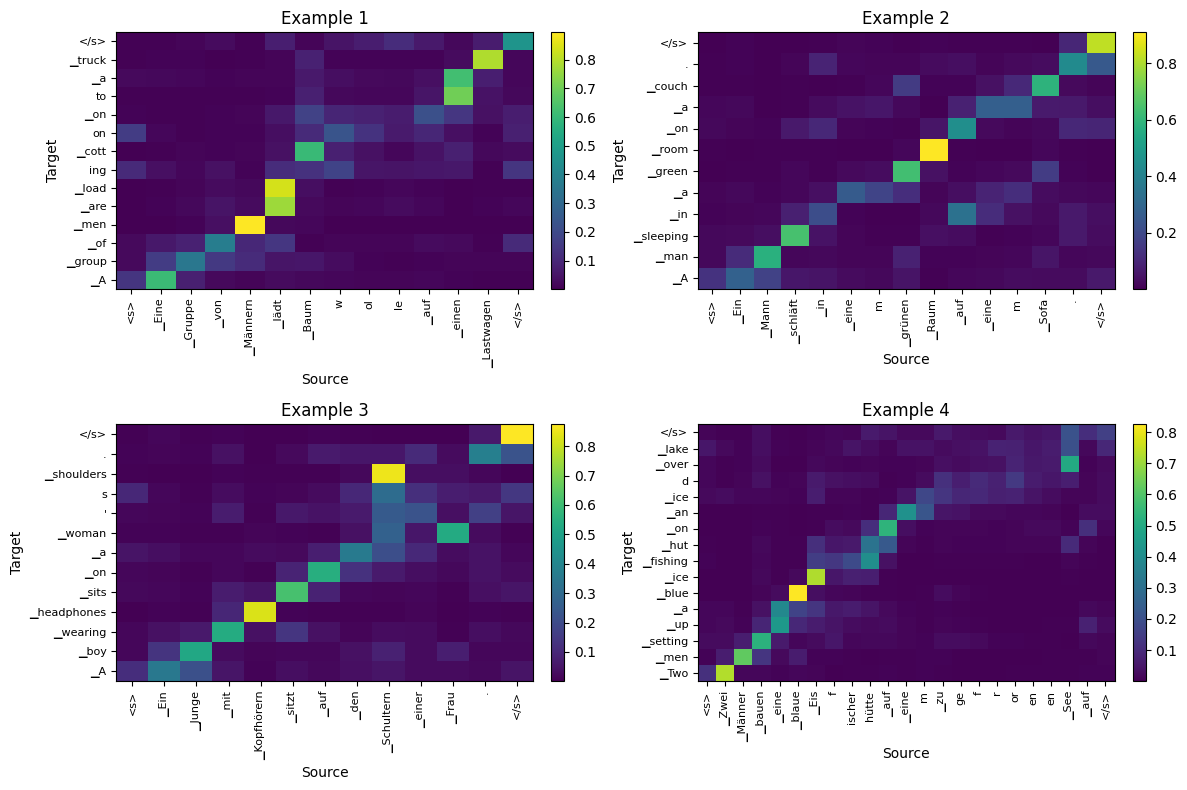

In [75]:
# You may find the following annotated heatmap tutorial helpful:
# https://matplotlib.org/3.1.3/gallery/images_contours_and_fields/image_annotated_heatmap.html.

attention_model.eval()
examples = list(validation_data)[:4]
source_sents = [ex.src for ex in examples]
target_sents = [ex.trg for ex in examples]

with torch.no_grad():
    source_batch = make_batch(source_sents)
    target_batch = make_batch(target_sents)
    encoder_out, encoder_mask, encoder_hidden = attention_model.encode(source_batch)
    decoder_in = target_batch[:-1]
    logits, _, attention = attention_model.decode(decoder_in, encoder_hidden, encoder_out, encoder_mask)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.ravel()):
    enc_ids = source_batch[:, i].tolist()
    dec_ids = target_batch[1:, i].tolist()
    enc_tokens = [vocab.IdToPiece(t) for t in enc_ids if t not in (pad_id,)]
    dec_tokens = [vocab.IdToPiece(t) for t in dec_ids if t not in (pad_id,)]


    A = attention[:len(dec_tokens), i, :len(enc_tokens)].cpu().numpy()  # (T_dec, T_enc)

    im = ax.imshow(A, aspect='auto', origin='lower')
    ax.set_xticks(range(len(enc_tokens)))
    ax.set_yticks(range(len(dec_tokens)))
    ax.set_xticklabels(enc_tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(dec_tokens, fontsize=8)
    ax.set_xlabel("Source"); ax.set_ylabel("Target")
    ax.set_title(f"Example {i+1}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

I think that the maps show that there are clear mapping between words in German and words in English. This is because we can see that the diagonals have high weights. Additionally, we see that in some cases, the mapping is off-diagonal. This means that the German word order differs from the English word order and our model is able to learn this re-ordering. Some of the attention weights are also split across multiple words which may indicate that the model has learned mappings from multiple words in German to single words in English.

# 5. Extra Credit: Beam Search (optional; 10 bonus points)

For extra credit, let's implement beam search.

Similar to greedy search, beam search generates one token at a time. However, rather than keeping only the single best hypothesis, we instead keep the top $k$ candidates at each time step. This is accomplished by computing the set of next-token extensions for each item on the beam and finding the top $k$ across all candidates according to total log-probability.

Candidates that are finished should stay on the beam through the end of inference. The search process concludes once all $k$ items on the beam are complete.

With beam search, you should get an improvement of at least 0.5 BLEU over greedy search, and should reach above 21 BLEU without attention and above 37 BLEU with attention.

**Tips:**

1) A good general strategy when doing complex code like this is to carefully annotate each line with a comment saying what each dimension represents.

2) You should only need one call to topk per step. You do not need to have a topk just over vocabulary first, you can directly go from vocab_size*beam_size to beam_size items.

3) Be sure you are correctly keeping track of which beam item a candidate is selected from and updating the beam states, such as LSTM hidden state, accordingly. A single state from the previous time step may need to be used for multiple new beam items or not at all. This includes all state associated with a beam, including all past tokens output by the beam and any extra tensors such as ones remembering when a beam is finished.

4) Pay attention to how you interleave things when using a single dimension to represent multiple things.  It will make a difference when you start reshaping to separate them out.  It may be easier to start with everything separate, then temporarily combine as needed.

5) For efficiency, we suggest that you implement all beam manipulations using batched PyTorch computations rather than Python for-loops.

6) Once an EOS token has been generated, force the output for that candidate to be padding tokens in all subsequent time steps by adding a large positive number like 1e9 to the appropriate logits. This will ensure that the candidate stays on the beam, as its probability will be very close to 1 and its score will effectively remain the same as when it was first completed.  All other (invalid) token continuations will have extremely low log probability and will not make it onto the beam.

7) While you are encouraged to keep your tensor dimensions constant for simplicity (aside from the sequence length), some special care will need to be taken on the first iteration to ensure that your beam doesn't fill up with k identical copies of the same candidate.


In [ ]:
def predict_beam(model, sentences, k=5, max_length=100):
  """Make predictions for the given inputs using beam search.

  Args:
    model: A sequence-to-sequence model.
    sentences: A list of input sentences, represented as strings.
    k: The size of the beam.
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference.

  Returns:
    A list of beam predictions. Each element in the list should be a list of k
    strings corresponding to the top k predictions for the corresponding input,
    sorted in descending order by score.
  """

  # Requirement: your implementation must be batched. This means that you should
  # make only one call to model.encode() at the start of the function, and make
  # only one call to model.decode() per inference step.

  # Does top-k return relative ordering, if not how to return at end of method?
  # EOS candidate getting knocked.

  # YOUR CODE HERE
  ...

  # BEGIN SOLUTION

  # END SOLUTION

print("Baseline model validation BLEU using beam search:",
      evaluate(baseline_model, validation_data, method="beam"))
print()
print("Baseline model sample predictions:")
print()
show_predictions(baseline_model, include_beam=True)

In [ ]:
print("Attention model validation BLEU using beam search:",
      evaluate(attention_model, validation_data, method="beam"))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model, include_beam=True)